# ECal Convolutional Neural Network detector.
This notebook is a test best to try CNN (Convolutional Neural Networks) to detect clusters in the ECal and to assign
these clusters the correct energy and position. CNNs are used in computer vision for far more challenging tasks.

For the initial data I use single electron or positron, or single muon (+ or -). Situations with multiple clusters and multiple particles can be
done later, either by a separate algorith to detect the individual clusters (which can be a an "object detection" CNN or FCNN
(fully convolutional NN), or by training a CNN to find multiple objects.



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../Python")
import ROOT as R
from array import array
import time
import numpy as np
# Turn jsroot off if you want to make a pdf from this file.
%jsroot off
from root_helpers import SetStyle
from root_helpers import fancy_plot
from root_helpers import print_mc_particle_tree
from root_helpers import print_daughters
# R.EnableImplicitMT()


Welcome to JupyROOT 6.29/01


In [2]:
import os
recompile = True
try:
    if os.path.getmtime('../Python/Utility_Functions_C.so') - os.path.getmtime('../Python/Utility_Functions.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Utility_Functions.C++")
else:
    R.gSystem.Load("../Python/Utility_Functions_C.so")
R.Utility_Functions()

R.gSystem.Load("/data/HPS/lib/libMiniDST")
R.gSystem.Load("/data/HPS/Analysis/lib/libEcal_Analysis")
R.gInterpreter.ProcessLine('''auto EAC = Ecal_Analysis_Class();''')   # This is key. It puts the EAC in C++ space.
print(f"{R.EAC.Version()}")

Recompile is not needed
V1.0.9


In [3]:
ch = R.TChain("MiniDST")
#ch.Add("/data/HPS/data/physrun2019/pass0/minidst/hps_010610_00030.root")
#ch.Add("/data/HPS/data/MC/emumu_calchep/events*.root")
#ch.Add("/data/HPS/data/MC/mup_2019/mup_1_2019.root")
ch.Add("/data/HPS/data/MC/ele_2019/ele_*_slic_recon.root")
print(f"Number of events loaded: {ch.GetEntries():8d}")
mdst = R.MiniDst()          # Initiate the class
mdst.use_mc_particles=True  # Tell it to look for the MC Particles in the TTree
mdst.use_ecal_cluster_uncor = True
mdst.use_mc_scoring =True
mdst.DefineBranchMap()      # Define the map of all the branches to the contents of the TTree
mdst.SetBranchAddressesOnTree(ch) # Connect the TChain (which contains the TTree) to the class.
print(f"MminiDST version = {mdst._version_()}")
event = 0

Number of events loaded:  6966485
MminiDST version = 1.1.0


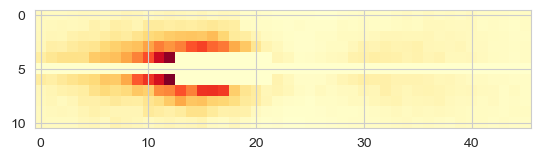

In [4]:
# Build an image of the ECal hits.
event = 0
ecal_hits = np.zeros([11,46],dtype=np.float32)
for event in range(event,event+10000):
    ch.GetEntry(event)
    for i_hit in range(len(mdst.ecal_hit_energy)):
        x_loc = mdst.ecal_hit_index_x[i_hit]
        if x_loc < 0:
            x_loc += 23
        else:
            x_loc += 22
        ecal_hits[mdst.ecal_hit_index_y[i_hit]+5,x_loc] += mdst.ecal_hit_energy[i_hit]
plt.imshow(ecal_hits,cmap="YlOrRd") #cmap="gray"
plt.show()

## Buid the CNN model

Most CNNs provide a table output where each entry in the table is the probability that this is the correctly assigned "label". In our case we want 3 floats as output, representing the energy, x-position and y-position.

The "loss" can be defined simply as the sum of differences between the true values and estimated values of the energy, x-position and y-position. The "accuracy" of the prediction would need to be the number of times the prediction is within some tolerance value. This is not pre-encoded in TensorFlow so I define my own class, FloatCompareAccuracy (and for completeness also have the IntCompareAccuracy class)


In [5]:
from keras import backend
def float_matches(y_true, y_pred, accuracy=1e-2):
    """Creates int Tensor, 1 if y_true is equal to y_pred within accuracy, 0 if not.

    Args:
      y_true: Ground truth values, of shape (batch_size, d0, .. dN).
      y_pred: The predicted values, of shape (batch_size, d0, .. dN).
      accuracy: (Optional) Float representing the fractional accuracy for deciding
        whether prediction values are 1 or 0.

    Returns:
      Binary matches, of shape (batch_size, d0, .. dN).
    """
    y_pred = tf.convert_to_tensor(y_pred)
    accuracy = tf.cast(accuracy, y_pred.dtype)
    result = tf.less(tf.abs(y_true - y_pred)/y_true, accuracy)
    return tf.cast(result, backend.floatx())


class IntCompareAccuracy(tf.keras.metrics.Accuracy):
    """Compare whether the predicted float values round to the truth integer values."""
    def __init__(self, name='int_compare_accuracy', **kwargs):
        super(IntCompareAccuracy, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred+0.5, tf.int32)
        super().update_state(y_true, y_pred)

class FloatCompareAccuracy(tf.keras.metrics.MeanMetricWrapper):
    """Compare whether the predicted float values are within Accuracy_tolerance of the truth float values."""
    def __init__(self, name='float_compare_accuracy', **kwargs):
        super().__init__(float_matches, name=name, **kwargs)


In [6]:
y_true = [0.1,0.5,6.3,8.4,9.1]
y_pred = [0.100,0.50,6.3,8.4,9.1]
print(float_matches(y_true,y_pred))
m = FloatCompareAccuracy()
m.update_state(y_true,y_pred)
m.result()

tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-07-21 17:26:38.409374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 17:26:38.409664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Define the model
Simple model, use CNN and then fully connected layers.

In [7]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 5, activation='relu')
        self.conv2 = Conv2D(64, 3, activation='relu')
        self.conv3 = Conv2D(128, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(128,activation='relu')
        self.d3 = Dense(3)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

# Create an instance of the model
model = MyModel()

# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_accuracy = FloatCompareAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_accuracy = FloatCompareAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

# Prepare the data
We make an "image" from each event. Initially we are making one image for each identified cluster.
The "truth" comes from the mc_score information, the particles that went through the scoring plane in front of the ecal. These
are grouped into clusters and the energy and position of these clusters is used as "truth".

In [8]:
event = 0
mini_batch = 50000 # 290000
y_size = 12
x_size = 47
y_scaling = 100   # Scale the x and y variables to reduce the contribution to the loss.
x_scaling = 100
ecal_hits = np.zeros([mini_batch,y_size,x_size,1],dtype=np.float32)
ecal_truth = np.zeros([mini_batch, 3])
ecal_energy = np.zeros([mini_batch, 3])
ecal_x = np.zeros([mini_batch, 2])
ecal_y = np.zeros([mini_batch, 2])

R.EAC.mc_score_indexes_are_sorted = True
out_evt = 0
n_event = 0
max_event = ch.GetEntries()
while out_evt < mini_batch:
    ch.GetEntry(event)
    cl_idx = R.EAC.get_score_cluster_indexes(mdst.mc_score_pz, mdst.mc_score_x, mdst.mc_score_y,
                                             mdst.mc_score_z, mdst.ecal_cluster_x, mdst.ecal_cluster_y)
    score_e = R.EAC.get_score_cluster_e(cl_idx, mdst.mc_score_px, mdst.mc_score_py, mdst.mc_score_pz)
    score_x = R.EAC.get_score_cluster_loc(cl_idx, mdst.mc_score_x, mdst.mc_score_pz)
    score_y = R.EAC.get_score_cluster_loc(cl_idx, mdst.mc_score_y, mdst.mc_score_pz)

    n_clust = len(mdst.ecal_cluster_uncor_energy)
    if n_clust > len(score_e):
        n_clust = len(score_e)
    for i_ecal in range(n_clust):
        for i_echit in range(len(mdst.ecal_cluster_uncor_hits[i_ecal])):
            i_hit = mdst.ecal_cluster_uncor_hits[i_ecal][i_echit]
            x_loc = mdst.ecal_hit_index_x[i_hit]
            if x_loc < 0:
                x_loc += 24
            else:
                x_loc += 23
            y_loc = mdst.ecal_hit_index_y[i_hit]+6
            ecal_hits[out_evt][y_loc, x_loc][0] = mdst.ecal_hit_energy[i_hit]
        mc_id = mdst.ecal_cluster_mc_id[i_ecal]
        i_cl = cl_idx[i_ecal]
        # ecal_truth[out_evt][0] = mdst.mc_part_energy[mc_id]   ## To train for MC_particle energy truth
        # print(f"{evt:5d} cl_e = {mdst.ecal_cluster_energy[i_ecal]}  s_e = {score_e[i_ecal]}  mc_e = {mdst.mc_part_energy[mc_id]}")
        ecal_truth[out_evt][0] = score_e[i_ecal]
        ecal_truth[out_evt][1] = score_x[i_ecal]/x_scaling
        ecal_truth[out_evt][2] = score_y[i_ecal]/y_scaling
        ecal_energy[out_evt]= [mdst.ecal_cluster_energy[i_ecal], score_e[i_ecal], mdst.mc_part_energy[mc_id]]
        ecal_x[out_evt]= [mdst.ecal_cluster_x[i_ecal]/x_scaling, score_x[i_ecal]/x_scaling]
        ecal_y[out_evt]= [mdst.ecal_cluster_y[i_ecal]/y_scaling, score_y[i_ecal]/y_scaling]
        out_evt += 1
        if out_evt >= mini_batch:
            break
    event += 1
    if event >= max_event:
        break
    n_event += 1
print(f"n_event = {n_event}  out_evt = {out_evt}  event = {event}")


n_event = 74889  out_evt = 50000  event = 74889


In [74]:
x_train = ecal_hits[:mini_batch//2]
y_train = ecal_truth[:mini_batch//2]
x_test = ecal_hits[mini_batch//2:]
y_test = ecal_truth[mini_batch//2:]
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(mini_batch).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [75]:
EPOCHS = 10

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result():10.7f}, '
        f'Accuracy: {train_accuracy.result() * 100:6.3f}%, '
        f'Test Loss: {test_loss.result():10.7f}, '
        f'Test Accuracy: {test_accuracy.result() * 100:6.3f}%'
    )

Epoch 1, Loss: 26.8693676, Accuracy: 33.488%, Test Loss:  0.2365700, Test Accuracy: 33.936%
Epoch 2, Loss:  0.1975605, Accuracy: 34.248%, Test Loss:  0.1993277, Test Accuracy: 34.371%
Epoch 3, Loss:  0.1655289, Accuracy: 34.661%, Test Loss:  0.1617814, Test Accuracy: 34.063%
Epoch 4, Loss:  0.1488046, Accuracy: 34.873%, Test Loss:  0.1732092, Test Accuracy: 34.351%
Epoch 5, Loss:  0.1381699, Accuracy: 34.964%, Test Loss:  0.1349539, Test Accuracy: 35.092%
Epoch 6, Loss:  0.1287146, Accuracy: 35.187%, Test Loss:  0.1255095, Test Accuracy: 35.584%
Epoch 7, Loss:  0.1200779, Accuracy: 35.439%, Test Loss:  0.1130493, Test Accuracy: 36.053%
Epoch 8, Loss:  0.1145248, Accuracy: 35.636%, Test Loss:  0.1151435, Test Accuracy: 36.035%
Epoch 9, Loss:  0.1090021, Accuracy: 35.853%, Test Loss:  0.1127938, Test Accuracy: 35.381%
Epoch 10, Loss:  0.1067395, Accuracy: 35.953%, Test Loss:  0.1124211, Test Accuracy: 35.815%



# Check the results
Compare the energy from the ECal clusters to the score plane energy and the predicted energy from the model.

In [76]:
pred = model(x_test, training=False)

In [81]:
np.sqrt(np.mean(np.square(pred-y_test)))

0.33539602

In [123]:
rdf = R.RDF.FromNumpy({'ecal_cluster_energy':ecal_energy[mini_batch//2:,0],'score_e':ecal_energy[mini_batch//2:,1] , 'mc_part_energy':ecal_energy[mini_batch//2:,2],'truth_e':y_test[:,0], 'truth_x':y_test[:,1]*x_scaling, 'truth_y':y_test[:,2]*x_scaling ,'pred_e':pred[:,0].numpy(), 'pred_x':pred[:,1].numpy()*x_scaling, 'pred_y':pred[:,2].numpy()*y_scaling})

In [124]:
h_cluster_e = rdf.Histo1D(("h_cluster_e","ECal cluster energy;E [GeV]",400,-0.5,6.),"ecal_cluster_energy")
h_mcpart_e = rdf.Histo1D(("h_mc_part_e","MC Particle energy",400,-0.5,6.),"mc_part_energy")
h_score_e = rdf.Histo1D(("h_score_e","Score energy",400,-0.5,6.),"score_e")
h_truth_e = rdf.Histo1D(("h_truth_e","Truth energy",400,-0.5,6.),"truth_e")
h_pred_e = rdf.Histo1D(("h_pred_e","Predicted energy",400,-0.5,6.),"pred_e")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc1


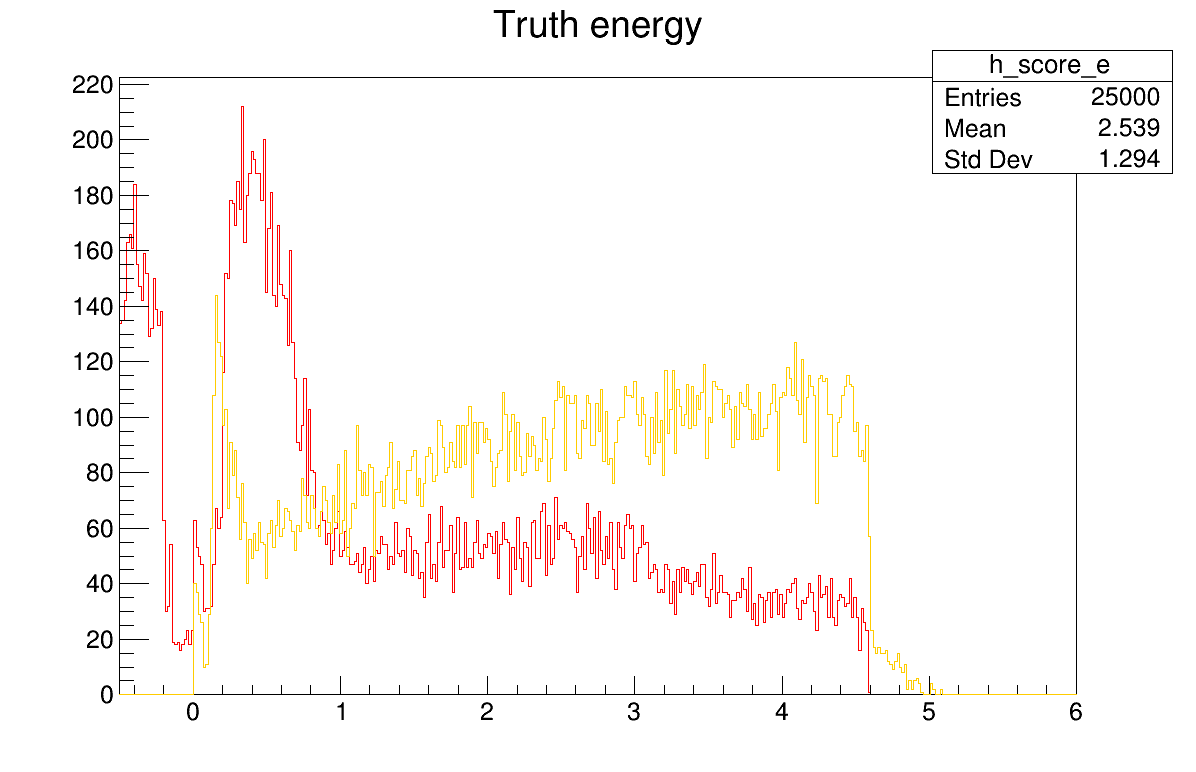

In [128]:
cc1 = R.TCanvas("cc1","CC1",1200,800)
h_truth_e.SetLineWidth(1)
h_truth_e.SetLineColor(R.kRed)
h_truth_e.Draw()
h_score_e.SetLineColor(R.kOrange)
h_score_e.Draw("same")
#h_cluster_e.SetLineColor(R.kBlue)
#h_cluster_e.Draw("same")
#h_mcpart_e.SetLineColor(R.kGreen)
#h_mcpart_e.Draw("same")
cc1.Draw()

In [103]:
y_train

<tf.Tensor: shape=(25000,), dtype=float32, numpy=
array([244.18245 , -47.858685, 161.73732 , ..., 101.289   , 333.3563  ,
        65.85432 ], dtype=float32)>

In [119]:
type(score_e)

<class cppyy.gbl.std.vector<double> at 0x2ba267cd0>